In [ ]:
import xarray as xr  # For handling NetCDF files
import pandas as pd  # For general data manipulation
import matplotlib.pyplot as plt  # For visualization
import os 
import geopandas as gpd #for handling the shapefile
import numpy as np


In [ ]:
path_Climate_Data = r'C:\Programe Files\Python311\Scripts\TP data mining\myenv\Projet-DM\Climate-DATA'
path_Country_shp = r'C:\Programe Files\Python311\Scripts\TP data mining\myenv\Projet-DM\Country\Country.shp'
path_save_Climate_data = r'C:\Users\Amatek\OneDrive\Bureau\projet DM\climate_dz.csv'

PSurf shape: (8760, 360, 720)
Qair shape: (8760, 360, 720)
Rainf shape: (8760, 360, 720)
Snowf shape: (8760, 360, 720)
Tair shape: (8760, 360, 720)
Wind shape: (8760, 360, 720)
---------------------------------------------
             AREA  PERIMETER  CNT1M_1_  CNT1M_1_ID FAO_NAME  FAO_CODE  \
12822  213.434727  73.435570     12824       11914  Algeria         4   
13013    0.000072   0.033402     13015       11939  Algeria         4   
13017    0.000111   0.044937     13019       11942  Algeria         4   

       UN_CODE ISO_CODE CNTRY_NAME ISO3_CODE  \
12822       12       DZ    Algeria       DZA   
13013       12       DZ    Algeria       DZA   
13017       12       DZ    Algeria       DZA   

                                                geometry  
12822  POLYGON ((7.51832 37.03624, 7.52736 37.02525, ...  
13013  POLYGON ((-0.89577 35.77688, -0.89942 35.77692...  
13017  POLYGON ((-1.13231 35.72762, -1.13595 35.72835...  


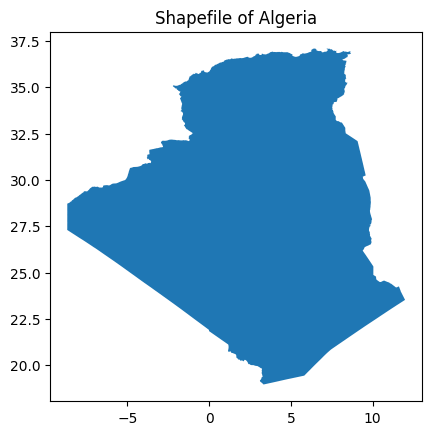

--------------------------------------------
PSurf shape: (8760, 36, 41)
Qair shape: (8760, 36, 41)
Rainf shape: (8760, 36, 41)
Snowf shape: (8760, 36, 41)
Tair shape: (8760, 36, 41)
Wind shape: (8760, 36, 41)


In [ ]:

folder_path = path_Climate_Data
file_paths = [os.path.join(folder_path, file) for file in os.listdir(folder_path) if file.endswith('.nc')]
climate_data = xr.open_mfdataset(file_paths, combine='by_coords')
climate_data = climate_data.rio.write_crs("EPSG:4326")
for var in climate_data.data_vars:
    print(f"{var} shape: {climate_data[var].shape}")

print('---------------------------------------------')
#algeria shape 
world_shapefile = gpd.read_file(path_Country_shp)
algeria_shape = world_shapefile[world_shapefile['CNTRY_NAME'] == 'Algeria']
#print algeria shape 
print(algeria_shape)
algeria_shape.plot()
plt.title("Shapefile of Algeria")
plt.show()

print('--------------------------------------------')
algeria_climate_data = climate_data.rio.clip(algeria_shape.geometry, algeria_shape.crs, drop=True)
for var in algeria_climate_data.data_vars:
    print(f"{var} shape: {algeria_climate_data[var].shape}")

In [60]:
# goal of this part to convert algeria climat_data to pandas dataframe 
aspring_climate_dataframe = algeria_climate_data.sel(time=slice("2019-03-21", "2019-06-20"))
aspring_climate_dataframe = aspring_climate_dataframe.to_dataframe().reset_index().dropna()

asummer_climate_dataframe = algeria_climate_data.sel(time=slice("2019-06-21", "2019-09-20"))
asummer_climate_dataframe = asummer_climate_dataframe.to_dataframe().reset_index().dropna()

afall_climate_dataframe = algeria_climate_data.sel(time=slice("2019-09-21", "2019-12-20")) 
afall_climate_dataframe = afall_climate_dataframe.to_dataframe().reset_index().dropna()

start_date1 = np.datetime64('2019-01-01')
end_date1 = np.datetime64('2019-03-20')
start_date2 = np.datetime64('2019-12-21')
end_date2 = np.datetime64('2019-12-31')
awinter_climate_dataframe = algeria_climate_data.where(
    ((algeria_climate_data['time'] >= start_date2) & (algeria_climate_data['time'] <= end_date2))|
    ((algeria_climate_data['time'] >= start_date1) & (algeria_climate_data['time'] <= end_date1)),
    drop=True
)

awinter_climate_dataframe = awinter_climate_dataframe.to_dataframe().reset_index().dropna()
afall_climate_dataframe_climate_dataframe = afall_climate_dataframe.drop(columns=['spatial_ref'])
aspring_climate_dataframe= aspring_climate_dataframe.drop(columns=['spatial_ref'])
awinter_climate_dataframe = awinter_climate_dataframe.drop(columns=['spatial_ref'])
asummer_climate_dataframe = asummer_climate_dataframe.drop(columns=['spatial_ref'])

awinter_climate_dataframe['season'] = 'Winter'
afall_climate_dataframe['season'] = 'Fall'
asummer_climate_dataframe['season'] = 'Summer'
aspring_climate_dataframe['season'] = 'Spring'

algeria_climate_dataframe = pd.concat([awinter_climate_dataframe, afall_climate_dataframe, 
                                        asummer_climate_dataframe, aspring_climate_dataframe], 
                                       ignore_index=True)
algeria_climate_dataframe = algeria_climate_dataframe.drop(columns=['spatial_ref'])

In [61]:
type(algeria_climate_dataframe['time'][0])

pandas._libs.tslibs.timestamps.Timestamp

In [62]:
# this part to transfer and prepare dataframe for aggregation

#fall = fall.reset_index(drop=False)  
afall_climate_dataframe['PSurf'] = afall_climate_dataframe['PSurf'] / 100
#algeria_climate_dataframe['PSurf'] = algeria_climate_dataframe['PSurf'].astype(float).round(5)
afall_climate_dataframe['Tair'] = afall_climate_dataframe['Tair'] - 273.15
#algeria_climate_dataframe['Tair'] =algeria_climate_dataframe['Tair'].astype(float).round(5)
#dz['Wind'] =dz['Wind'].astype(float).round(5)
afall_climate_dataframe['Rainf']=afall_climate_dataframe['Rainf']*3600
afall_climate_dataframe['Snowf']=afall_climate_dataframe['Snowf']*3600
afall_climate_dataframe.columns = [col + '_f' for col in afall_climate_dataframe.columns]
#afall_climate_dataframe = afall_climate_dataframe.drop(columns=['season'])
#afall_climate_dataframe = afall_climate_dataframe.drop(columns=['spatial_ref'])

asummer_climate_dataframe['PSurf'] = asummer_climate_dataframe['PSurf'] / 100
#algeria_climate_dataframe['PSurf'] = algeria_climate_dataframe['PSurf'].astype(float).round(5)
asummer_climate_dataframe['Tair'] = asummer_climate_dataframe['Tair'] - 273.15
#algeria_climate_dataframe['Tair'] =algeria_climate_dataframe['Tair'].astype(float).round(5)
#dz['Wind'] =dz['Wind'].astype(float).round(5)
asummer_climate_dataframe['Rainf']=asummer_climate_dataframe['Rainf']*3600
asummer_climate_dataframe['Snowf']=asummer_climate_dataframe['Snowf']*3600
asummer_climate_dataframe.columns = [col + '_s' for col in asummer_climate_dataframe.columns]
#asummer_climate_dataframe = asummer_climate_dataframe.drop(columns=['season'])
#asummer_climate_dataframe = asummer_climate_dataframe.drop(columns=['spatial_ref'])

awinter_climate_dataframe['PSurf'] = awinter_climate_dataframe['PSurf'] / 100
#algeria_climate_dataframe['PSurf'] = algeria_climate_dataframe['PSurf'].astype(float).round(5)
awinter_climate_dataframe['Tair'] = awinter_climate_dataframe['Tair'] - 273.15
#algeria_climate_dataframe['Tair'] =algeria_climate_dataframe['Tair'].astype(float).round(5)
#dz['Wind'] =dz['Wind'].astype(float).round(5)
awinter_climate_dataframe['Rainf']=awinter_climate_dataframe['Rainf']*3600
awinter_climate_dataframe['Snowf']=awinter_climate_dataframe['Snowf']*3600
awinter_climate_dataframe.columns = [col + '_w' for col in awinter_climate_dataframe.columns]
#awinter_climate_dataframe = awinter_climate_dataframe.drop(columns=['season'])
#awinter_climate_dataframe = awinter_climate_dataframe.drop(columns=['spatial_ref'])


aspring_climate_dataframe['PSurf'] = aspring_climate_dataframe['PSurf'] / 100
#algeria_climate_dataframe['PSurf'] = algeria_climate_dataframe['PSurf'].astype(float).round(5)
aspring_climate_dataframe['Tair'] = aspring_climate_dataframe['Tair'] - 273.15
#algeria_climate_dataframe['Tair'] =algeria_climate_dataframe['Tair'].astype(float).round(5)
#dz['Wind'] =dz['Wind'].astype(float).round(5)
aspring_climate_dataframe['Rainf']=aspring_climate_dataframe['Rainf']*3600
aspring_climate_dataframe['Snowf']=aspring_climate_dataframe['Snowf']*3600
aspring_climate_dataframe.columns = [col + '_r' for col in aspring_climate_dataframe.columns]
#aspring_climate_dataframe = aspring_climate_dataframe.drop(columns=['season'])
#aspring_climate_dataframe = aspring_climate_dataframe.drop(columns=['spatial_ref'])

winter = awinter_climate_dataframe.groupby(['lat_w', 'lon_w', 'season_w']).mean().reset_index()
fall = afall_climate_dataframe.groupby(['lat_f', 'lon_f', 'season_f']).mean().reset_index()
summer = asummer_climate_dataframe.groupby(['lat_s', 'lon_s', 'season_s']).mean().reset_index()
spring = aspring_climate_dataframe.groupby(['lat_r', 'lon_r', 'season_r']).mean().reset_index()

winter.rename(columns={'lat_w': 'lat'}, inplace=True)
spring.rename(columns={'lat_r': 'lat'}, inplace=True)
summer.rename(columns={'lat_s': 'lat'}, inplace=True)
fall.rename(columns={'lat_f': 'lat'}, inplace=True)
winter.rename(columns={'lon_w': 'lon'}, inplace=True)
spring.rename(columns={'lon_r': 'lon'}, inplace=True)
summer.rename(columns={'lon_s': 'lon'}, inplace=True)
fall.rename(columns={'lon_f': 'lon'}, inplace=True)


In [63]:
# transfer numeric data unit to more readable and general unit 

algeria_climate_dataframe['PSurf'] = algeria_climate_dataframe['PSurf'] / 100
#algeria_climate_dataframe['PSurf'] = algeria_climate_dataframe['PSurf'].astype(float).round(5)
algeria_climate_dataframe['Tair'] = algeria_climate_dataframe['Tair'] - 273.15
#algeria_climate_dataframe['Tair'] =algeria_climate_dataframe['Tair'].astype(float).round(5)
#dz['Wind'] =dz['Wind'].astype(float).round(5)
algeria_climate_dataframe['Rainf']=algeria_climate_dataframe['Rainf']*3600
algeria_climate_dataframe['Snowf']=algeria_climate_dataframe['Snowf']*3600
algeria_climate_dataframe

,time,lat,lon,PSurf,Qair,Rainf,Snowf,Tair,Wind,season
0,2019-01-01 00:00:00,19.25,3.25,964.833191,0.002839,0.0,0.0,16.364746,3.637232,Winter
1,2019-01-01 00:00:00,19.25,3.75,970.202332,0.002797,0.0,0.0,16.407043,3.534133,Winter
2,2019-01-01 00:00:00,19.25,4.25,968.807434,0.002940,0.0,0.0,16.205627,3.620100,Winter
3,2019-01-01 00:00:00,19.25,4.75,967.047241,0.003037,0.0,0.0,16.021515,3.934568,Winter
4,2019-01-01 00:00:00,19.75,3.25,955.848511,0.002825,0.0,0.0,15.269409,3.322595,Winter
...,...,...,...,...,...,...,...,...,...,...
7459179,2019-06-20 23:00:00,24.25,10.75,907.321228,0.005078,0.0,0.0,28.855225,3.942075,Spring
7459180,2019-06-20 23:00:00,23.25,11.25,904.956238,0.004879,0.0,0.0,28.061554,5.281921,Spring
7459181,2019-06-20 23:00:00,23.75,11.25,913.488586,0.005205,0.0,0.0,28.701874,3.925229,Spring
7459182,2019-06-20 23:00:00,24.25,11.25,923.670654,0.005135,0.0,0.0,28.986908,3.709934,Spring


In [ ]:
#ave algeria climat dz to csv 
algeria_climate_dataframe.to_csv(path_save_Climate_data, index=False)